# Table of Contents

[Importing Libraries and Functions](#1)

[Project Description](#2)

[Project Instructions](#3)

[Data Description](#4)

[Data Preparation](#5)

[Data Analysis](#6)
- [Summary Statistics](#6.1)
- [Time Series Plots](#6.2)
- [Trends and Seasonality By Month and Season](#6.3)
- [Taxis Ordered By Hour of Day, Day of Week, and Month of Year](#6.4)

[Model Training & Testing](#7)
- [Features Engineering](#7.1)
- [Linear Regression](#7.2)
- [Random Forest](#7.3)
- [LightGBM Regressor](#7.4)
- [Sanity Check](#7.5)

[Conclusion](#8)

# Importing Libraries & Functions <a id=1></a>

In [1]:
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split
from sklearn.preprocessing import MaxAbsScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import math
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

# Project Description <a id=2></a>

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction. The RMSE metric on the test set must not be more than 48.

# Project Instructions <a id=3></a>

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

# Data Description <a id=4></a>

The data is stored in the file named `taxi.csv`, which has two columns.

**datetime** — Given in the following format: YYYY-MM-DD HH:MM:SS 

**num_orders** — The number of taxi orders made at the corresponding datetime.

# Data Preparation <a id=5></a>

In [2]:
data = pd.read_csv('taxi.csv')

First I would like to know whether or not there are any null values, and also whether or not there the Dtypes are appropriate.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Thankfully, there are no null values. 

While it makes sense for **num_orders** to have Dtype int64 (since one cannot have a decimal number of taxi orders, e.g. 40.5), the **datetime** column should be converted to Dtype datetime64[ns].

In [4]:
data['datetime'] = pd.to_datetime(data['datetime'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


I wonder if the DataFrame has any rows that are exact duplicates? If so, they should be dropped.

In [5]:
display(data[data.duplicated()])

,datetime,num_orders


Since the code above displays an empty DataFrame, that means there are no rows which are exact duplicates. Hence, I will not drop any rows.

I always like to display a random sample of rows from the DataFrames I examine in order to know what the data "looks like".

In [6]:
data.sample(10)

,datetime,num_orders
7496,2018-04-22 01:20:00,9
7761,2018-04-23 21:30:00,9
22991,2018-08-07 15:50:00,11
9826,2018-05-08 05:40:00,1
18515,2018-07-07 13:50:00,10
8895,2018-05-01 18:30:00,10
16948,2018-06-26 16:40:00,23
17923,2018-07-03 11:10:00,19
19522,2018-07-14 13:40:00,7
22864,2018-08-06 18:40:00,4


Now that the data has been preprocessed, I will make a new DataFrame where the index is set equal to the **datetime** column.

In [7]:
data_reindexed = data.set_index('datetime')

To check if the dates and times are in chronological order, let's look at the **is_monotonic_increasing** attribute of the table index.

In [8]:
print(data_reindexed.index.is_monotonic_increasing)

True


Great! Since the attribute returned "True", that means the order is chronological!

It would be good to know the start and end dates of the DataFrame. Displaying the head and tail of the DataFrame will reveal these dates. 

In [9]:
display(data.head())
display(data.tail())

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


,datetime,num_orders
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39
26495,2018-08-31 23:50:00,53


The earliest date in the DataFrame is the 1st of March 2018, whereas the latest date is the 31st of August 2018.

Notice that the times are always in increments of 10 minutes. My instructions include resampling the data by every 1 hour, which I do in the next line. This causes every 10-minute interval within the same hour to get grouped together, and the best aggregate value to use is the sum. This is because Sweet Lift Taxi wants to be able to predict the **total** amount of taxi orders for the next hour (how many taxi orders there are every 10 minutes is not perceived as important to the company, rather the company would prefer to use the data in 60-minute intervals).

In [10]:
data_reindexed = data_reindexed.resample('1H').sum()

data_reindexed = data_reindexed.rename(columns = {'num_orders': 'num_orders_hourly'})

C:\Users\18604\AppData\Local\Temp\ipykernel_48820\4054906281.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_reindexed = data_reindexed.resample('1H').sum()


# Data Analysis <a id=6></a>

**Summary Statistics** <a id=6.1></a>

First, I would like to use the **describe** function to get an idea of the distribution of the data.

In [11]:
data_reindexed.describe()

,num_orders_hourly
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


On average, there are about 84 taxi rides ordered every hour, with a standard deviation of about 45. 

The mean is pretty similar to the median, 78 taxi rides ordered every hour, but since the mean is larger, that suggests there are a considerable number of high outliers. I wonder how many outliers there are, both low and high.

According to the IQR method for detecting outliers, a value would be a low outlier in this dataset if it is less than Q1 – 1.5×IQR = 54 – 1.5×(107 – 54) = –25.5, so this dataset does not have any low outliers (after all, one cannot have a negative number of taxi orders).

On the flip side, a value would be a high outlier in this dataset if it is more than Q3 + 1.5×IQR = 107 + 1.5(107 – 54) = 186.5. There is at least one high outlier because the maximum value is 462 taxi orders, but how many exactly? 

In [12]:
upper_limit = data_reindexed.quantile(0.75) + 1.5*(data_reindexed.quantile(0.75) - data_reindexed.quantile(0.25))

print('There are', len(data_reindexed[data_reindexed['num_orders_hourly'] > upper_limit.item()]), 
      'high outliers in the dataframe which constitute', 
      round(len(data_reindexed[data_reindexed['num_orders_hourly'] > upper_limit.item()]) / len(data_reindexed) * 100, 2), 
      '% of the values of the dataframe.')

There are 121 high outliers in the dataframe which constitute 2.74 % of the values of the dataframe.


I think the best approach to dealing with these 121 high outliers is to clip their values to the **upper_limit** value. 

More specifically, I will clip those values to the **upper_limit** value rounded down to the nearest integer, since one cannot have 186.5 taxi orders.

In [13]:
data_reindexed_clipped = data_reindexed.clip(upper = math.floor(upper_limit), axis = 1)

data_reindexed['num_orders_hourly'] = data_reindexed_clipped

display(data_reindexed.describe())

C:\Users\18604\AppData\Local\Temp\ipykernel_48820\2363401892.py:1: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  data_reindexed_clipped = data_reindexed.clip(upper = math.floor(upper_limit), axis = 1)


,num_orders_hourly
count,4416.000000
mean,83.379755
std,41.485088
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,186.000000


I wonder what the histogram of the **num_orders_hourly** values looks like.

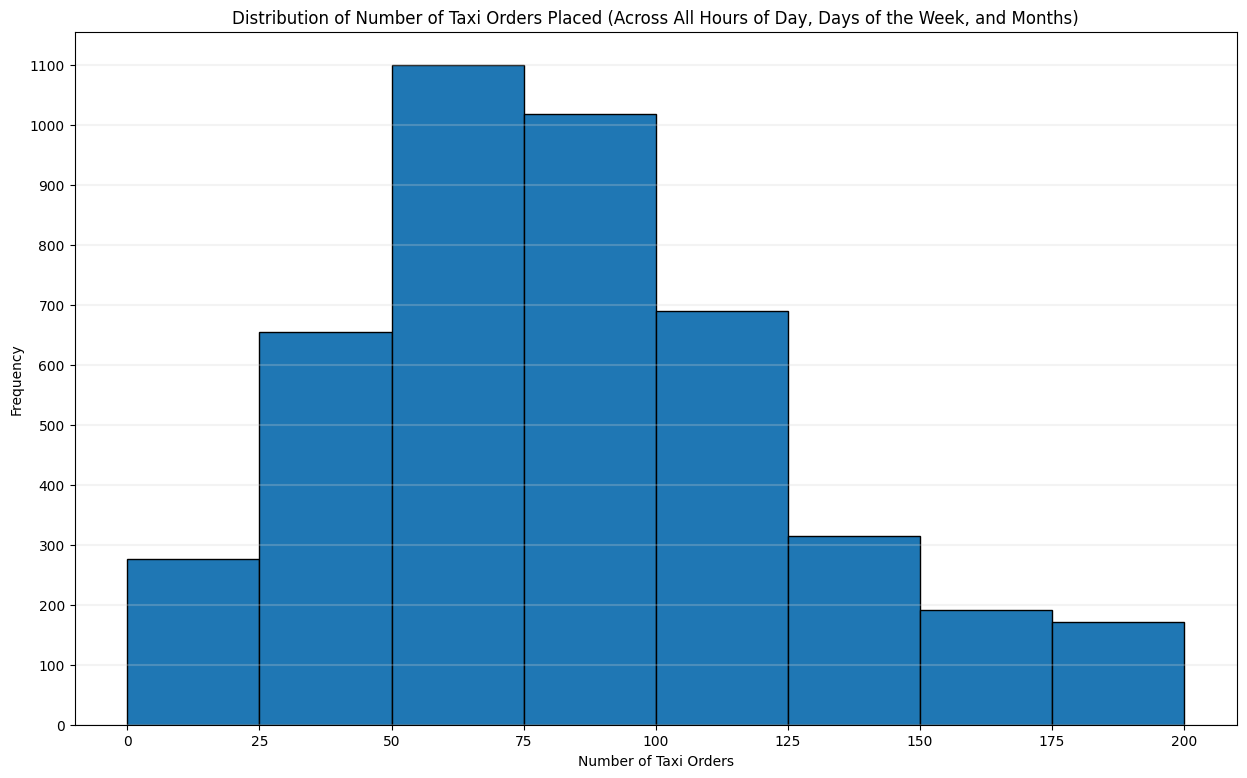

In [14]:
plt.figure(figsize = (15, 9))
data_reindexed['num_orders_hourly'].plot(kind = 'hist', bins = np.arange(0, 225, 25), edgecolor = 'black', linewidth = 1)

plt.title('Distribution of Number of Taxi Orders Placed (Across All Hours of Day, Days of the Week, and Months)')
plt.xlabel('Number of Taxi Orders')
plt.xticks(np.arange(0, 225, 25))
plt.ylabel('Frequency')
plt.yticks(np.arange(0, 1200, 100))

for y_tick in plt.gca().get_yticks():
    plt.axhline(y = y_tick, color = 'lightgray', linestyle = '-', alpha = 0.25)

Since all 121 outliers are high outliers, it makes sense that the distribution of taxi orders is slightly right-tailed, even though those values were clipped. 

I think Sweet Lift Taxi would benefit from knowing that 50 to 75 is the most common interval of number of taxis ordered in one hour at an airport, followed closely by 75 to 100 taxis ordered in one hour. 

Interestingly, 50 and 100 are similar in value to 54 and 107, respectively, which are the 25th and 75 percentile values, respectively. This means that 50% of the time the total number of taxi orders made in an hour is between 54 and 107 (inclusive). 

Hence, one can argue that Sweet Lift Taxi can treat an hour in which between 54 and 107 taxis are ordered as a "typical" hour.

**Time Series Plots** <a id=6.2></a>

Now let's see the plot of the time series graph.

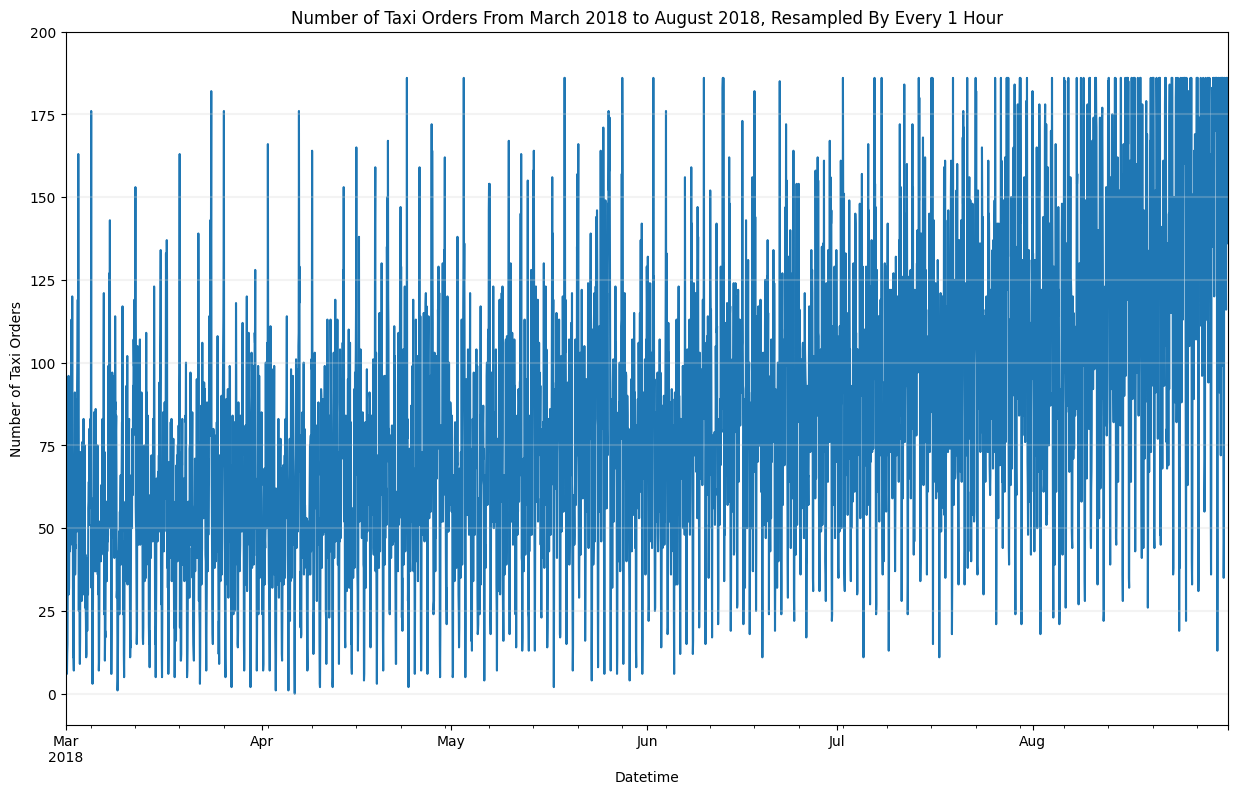

In [15]:
data_reindexed.plot(figsize = (15, 9), legend = False)
plt.title('Number of Taxi Orders From March 2018 to August 2018, Resampled By Every 1 Hour')
plt.xlabel('Datetime')
plt.ylabel('Number of Taxi Orders')
plt.yticks(np.arange(0, 225, 25))

for y_tick in plt.gca().get_yticks():
    plt.axhline(y = y_tick, color = 'lightgray', linestyle = '-', alpha = 0.25)

plt.show()

There appears to be an upward trend in the number of taxi orders as the graph goes from the start of March 2018 to the end of August 2018. More specifically, the trend seems to be relatively constant from the start of March to the start of June, but from the start of June onward the number of taxi orders per hour appears to increase. Given that June, July, and August are the summer months, maybe there are more people traveling during those months than others.

I wonder if plotting the time series graph with its rolling mean would give me a clearer visual of the upward trend.

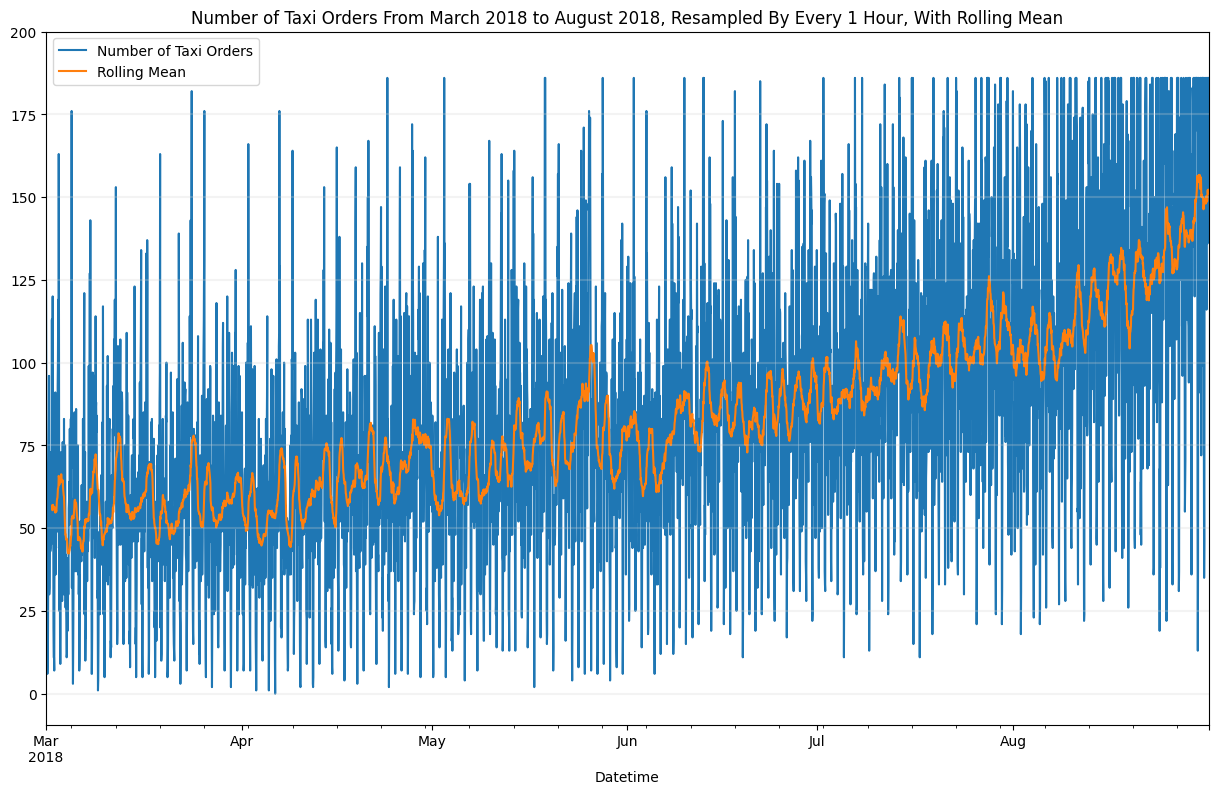

In [16]:
data_reindexed['rolling_mean'] = data_reindexed.rolling(24).mean() 

data_reindexed.plot(figsize = (15, 9))

plt.legend(['Number of Taxi Orders', 'Rolling Mean'])
plt.title('Number of Taxi Orders From March 2018 to August 2018, Resampled By Every 1 Hour, With Rolling Mean')
plt.xlabel('Datetime')
plt.yticks(np.arange(0, 225, 25))

for y_tick in plt.gca().get_yticks():
    plt.axhline(y = y_tick, color = 'lightgray', linestyle = '-', alpha = 0.25)

plt.show()

I do think that having the rolling mean plotted makes it even clearer that there is an upward trend. At the beginning of March, the rolling mean is approximately 50, whereas at the end of August it is approximately 150, which is about 3 times larger! This further supports my hunch that more people travel in the summer than in the spring, and consequently more taxi rides are ordered at airports in the summer than in the spring.

<u>SIDE NOTE</u>: Notice that I set the window size to 24. This is because there are 24 hours in a day.

Now I wonder if this time series is stationary or nonstationary. (Stationary means that the mean and the variance of the data is constant over the time frame of the series, and nonstationary is the opposite of that.) Thankfully, there exists an automated process called the augmented Dickey-Fuller (adfuller) unit root test to help me determine which it is.

In [17]:
train_stationarity, test_stationarity = train_test_split(data_reindexed.copy().drop('rolling_mean', axis = 1), 
                                                         shuffle = False, test_size = 0.1)

data_reindexed_stationarityTest = adfuller(train_stationarity, autolag = 'AIC')
print("P-value: ", data_reindexed_stationarityTest[1])

P-value:  0.0004148427261923472


Though these sorts of tests can never prove anything with 100% certainty, since the p-value returned by the test is less than 0.05 (in fact, it is extremely close to 0), it is very likely that the dataset is stationary. This has major implications regarding which machine learning models are appropriate to use with this data. 

**Trends and Seasonality By Month and Season** <a id=6.3></a>

It is difficult to tell if there are any trends and seasonality in the data using only the plots I have made so far, but it is worth it to keep looking for them because if there are any, Sweet Lift Taxi would benefit from knowing. I will now use the **seasonal_decompose** function to look for trends and seasonality one month at a time. I will also plot the trend of the spring months (March, April, and May) as well as plot the trend of the summer months (June, July, and August). 

In [18]:
decomposed = seasonal_decompose(data_reindexed.drop('rolling_mean', axis = 1))

Notice below that the x-axis ticks of both plots are 05, 12, 19, and 26. These are the days of March 2018 that were Mondays, and since Monday is usually considered the first day of the week, it is convenient to have the start of each week of March 2018 clearly labeled!

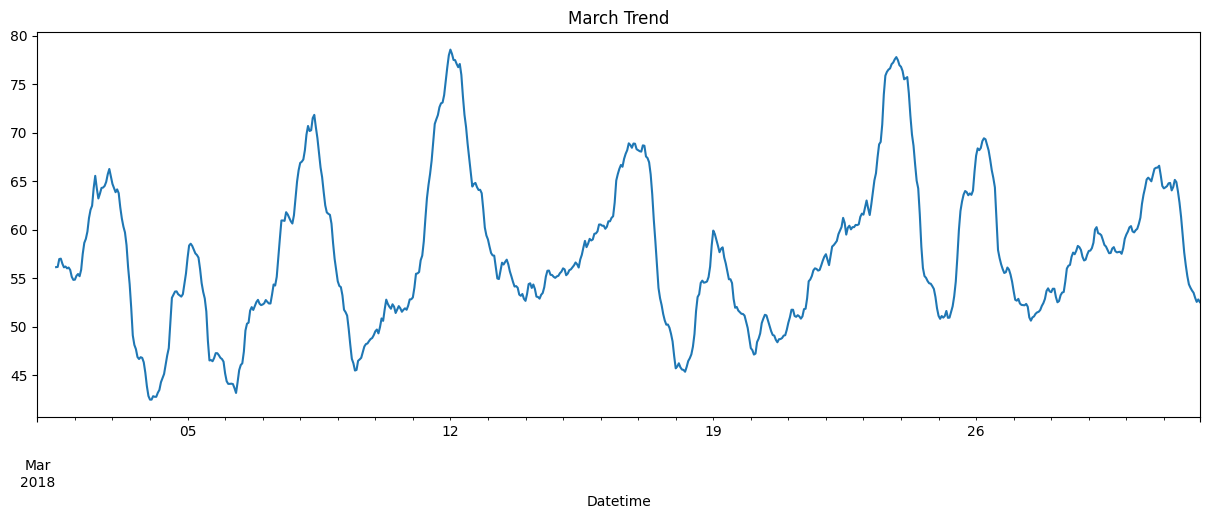

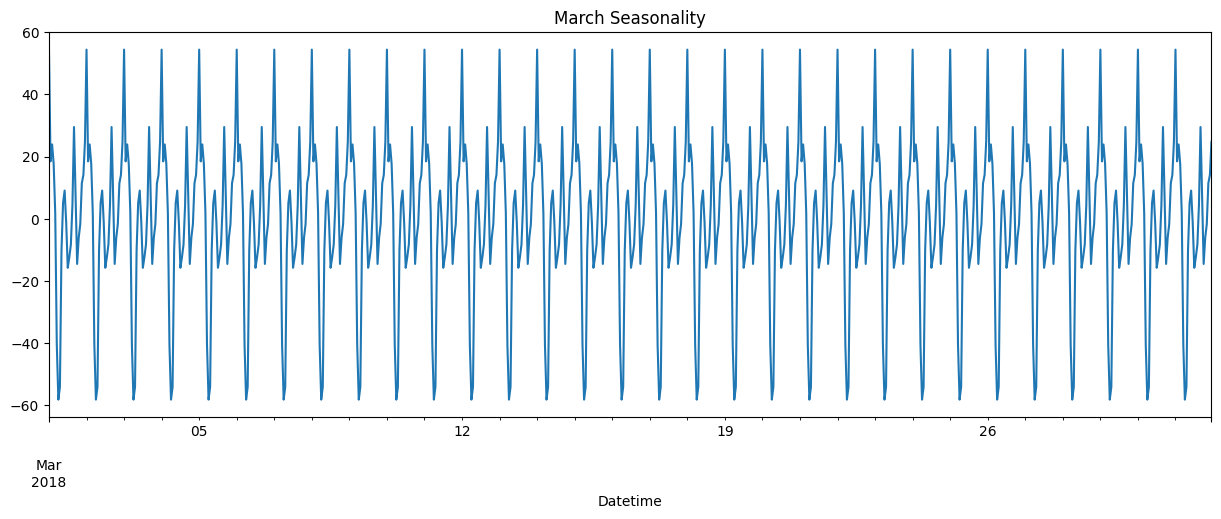

In [19]:
decomposed.trend['2018-03-01':'2018-03-31'].plot(figsize = (15, 5))
plt.title('March Trend')
plt.xlabel('Datetime')
plt.show()

decomposed.seasonal['2018-03-01':'2018-03-31'].plot(figsize = (15, 5))
plt.title('March Seasonality')
plt.xlabel('Datetime')
plt.show()

For the month of March, there is no apparent upward trend as the month progresses. I find it interesting how there is a local maximum on every Monday of March. However, it is not only the Mondays that have local maximums. 

- There is another occuring from the end of the day on Friday, March 2nd to the start of the day on Saturday, March 3rd. 

- Another on Thursday, March 8th. 

- Another from the end of the day on Friday, March 16th to the start of the day on Saturday, March 17th.

- Another from the end of the day on Friday, March 23rd to the start of the day on Saturday, March 24th.

- Another from the end of the day on Friday, March 30th to the start of the day on Saturday, March 31st.

Perhaps the local maximums which occur on late Friday and/or early Saturday could be explained by the fact that public transportation is not usually available at those hours, thereby (more or less) forcing people to have to order a taxi.

As for the local maximums on Mondays, maybe Monday is perceived as a desirable day to travel because it allows someone on vacation to have the full week available to them.

Regarding the seasonality of March, it appears to be periodic in a way that repeats every day. At the start of the day, the number of taxi orders is large, but by the time it has been about 1/4 of the way into the day the number has sharply dropped, and from that point onward there are three spikes upward until the day ends. This suggests to me that certain times in the days are much busier for taxi drivers than others.

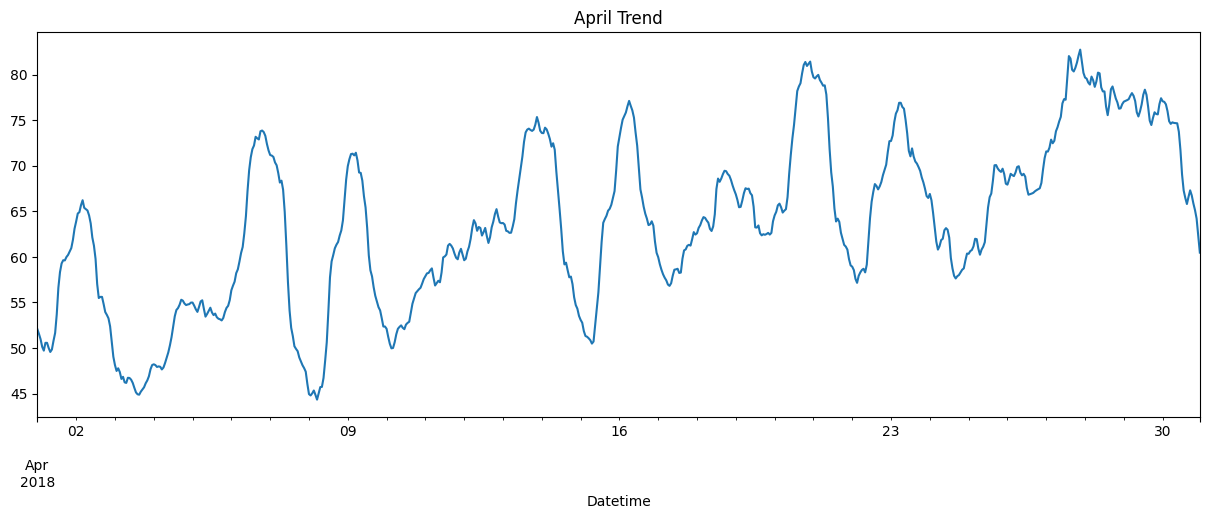

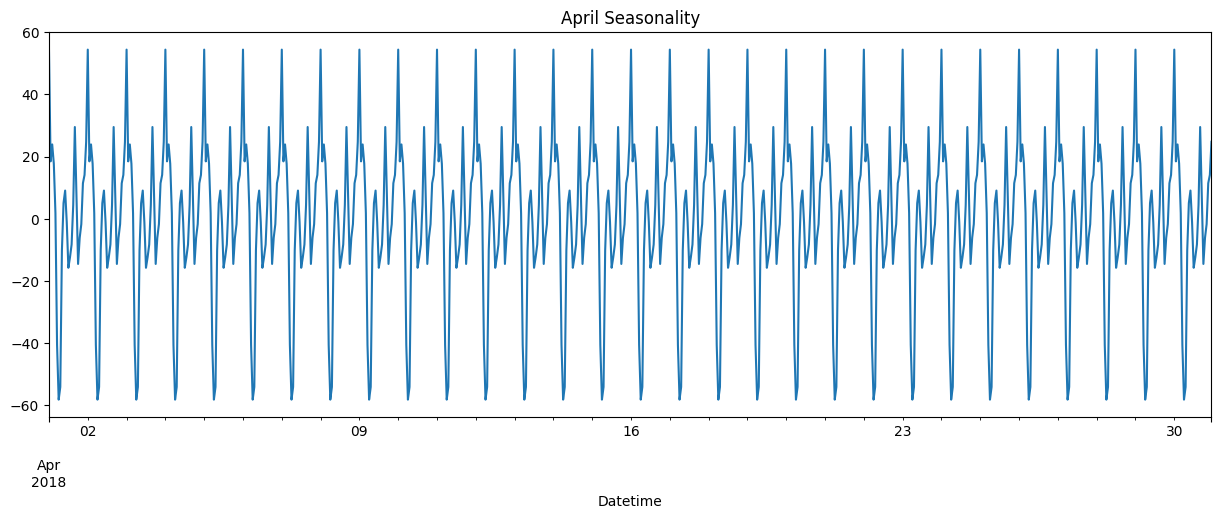

In [20]:
decomposed.trend['2018-04-01':'2018-04-30'].plot(figsize = (15, 5))
plt.title('April Trend')
plt.xlabel('Datetime')
plt.show()

decomposed.seasonal['2018-04-01':'2018-04-30'].plot(figsize = (15, 5))
plt.title('April Seasonality')
plt.xlabel('Datetime')
plt.show()

Notice that the x-ticks are now 02, 09, 16, 23, and 30 because these were the Mondays of April 2018.

April appears to have virtually the same seasonality as March. Unlike March, however, April has a noticeable upward trend from the beginning to the end of the month, especially from about April 10th onward.

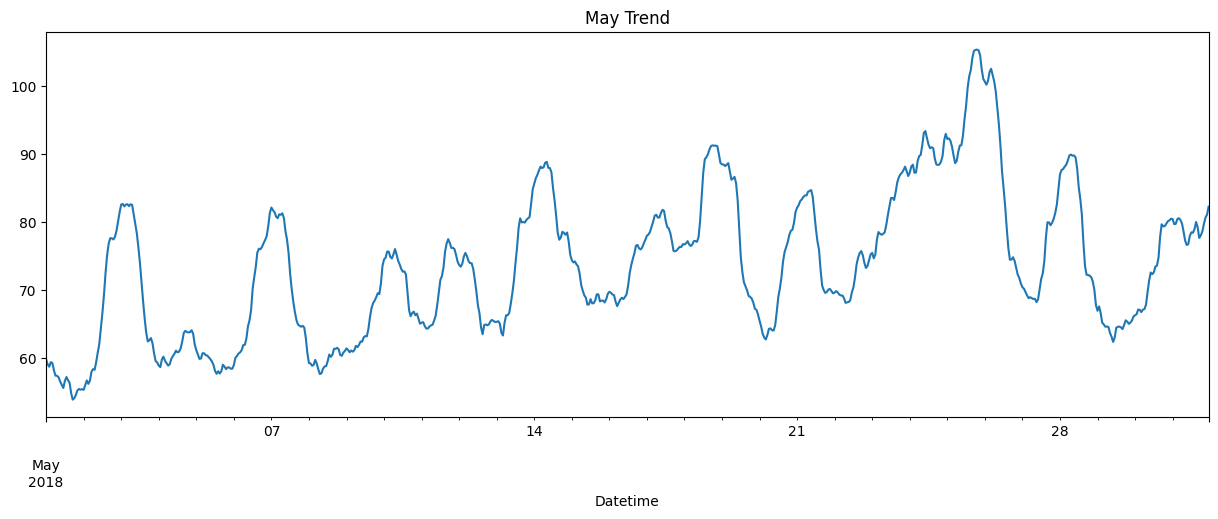

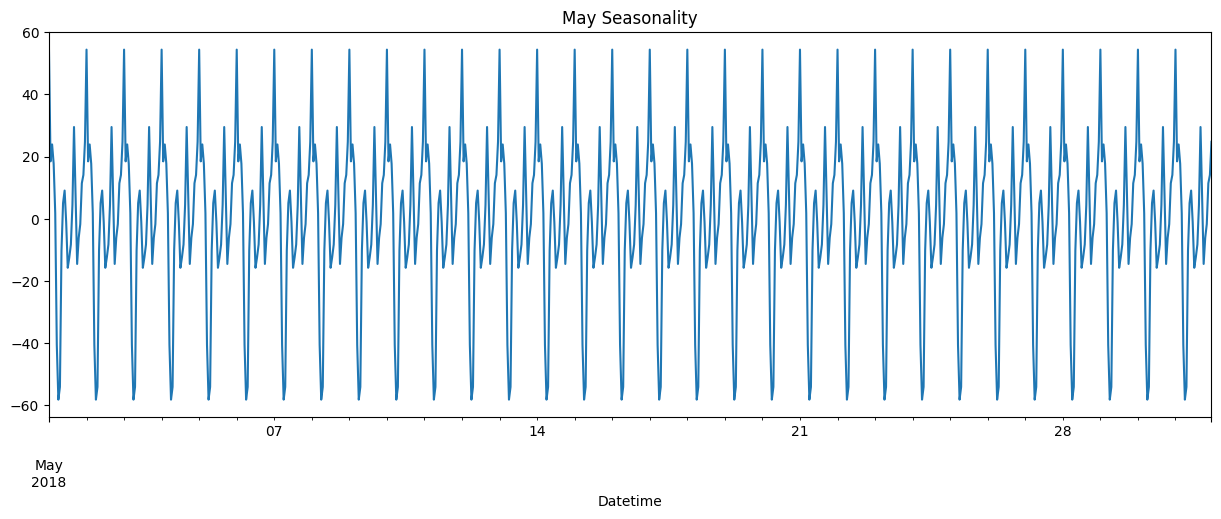

In [21]:
decomposed.trend['2018-05-01':'2018-05-31'].plot(figsize = (15, 5))
plt.title('May Trend')
plt.xlabel('Datetime')
plt.show()

decomposed.seasonal['2018-05-01':'2018-05-31'].plot(figsize = (15, 5))
plt.title('May Seasonality')
plt.xlabel('Datetime')
plt.show()

Notice the overall increase in the y-axis values of May's trend plot. This indicates that there continues to be an upward trend, although seasonality is still virtually the same.

I think it is useful to have a graph of the trend of the months of spring: March, April, and May. In fact, I think the following plot nicely illustrates how there is no apparent increase (or decrease) throughout March, but there clearly is an upward trend throughout April and May. Maybe this is because April and (especially) May are closer to summer than March, and therefore the weather is more suitable for traveling?

<u>SIDE NOTE</u>: I decided not to plot the seasonality of spring because that plot would be too "messy" to be useful. 

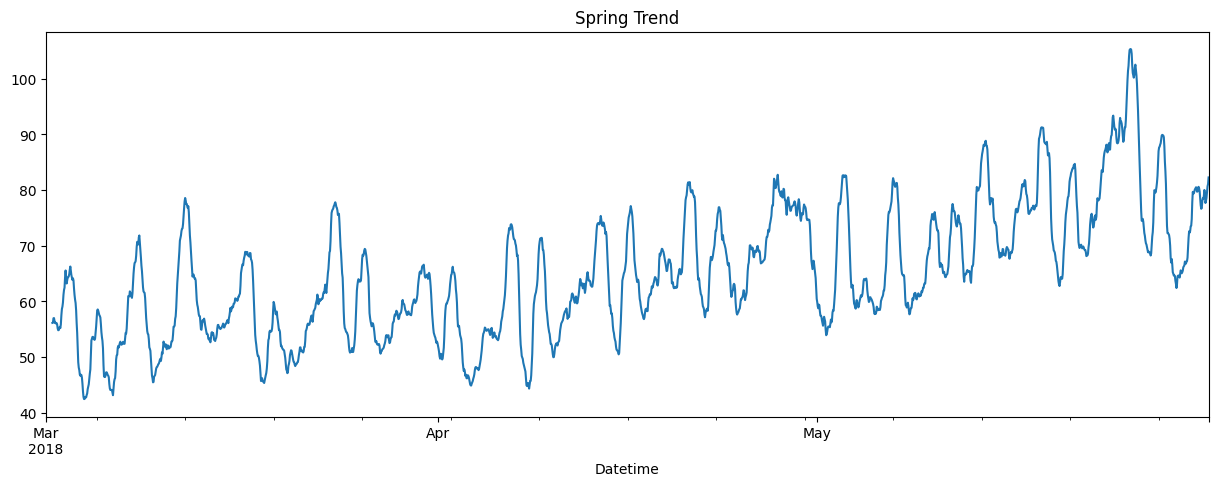

In [22]:
decomposed.trend['2018-03-01':'2018-05-31'].plot(figsize = (15, 5))
plt.title('Spring Trend')
plt.xlabel('Datetime')
plt.show()

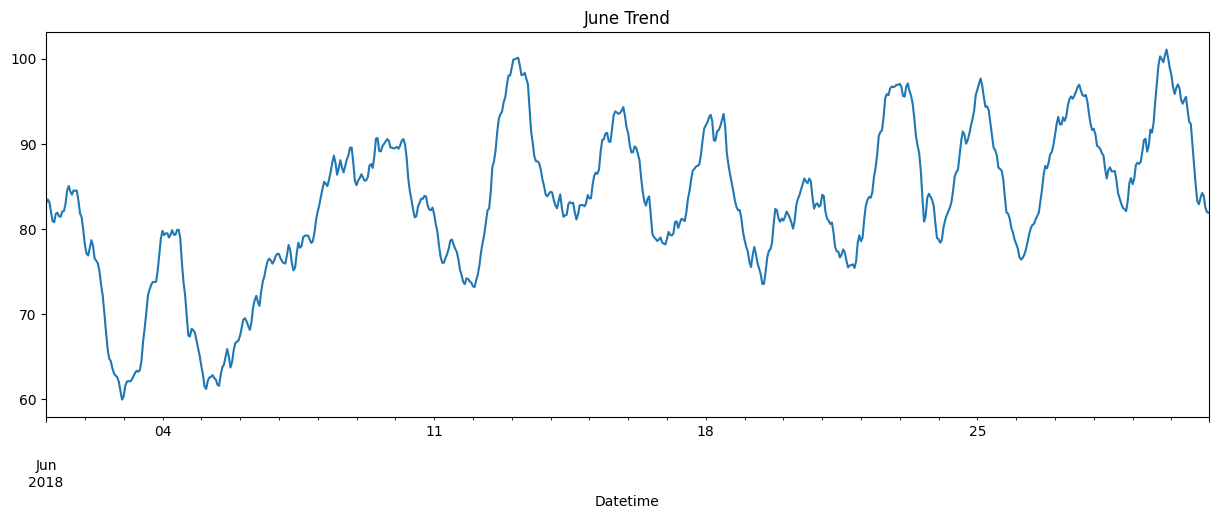

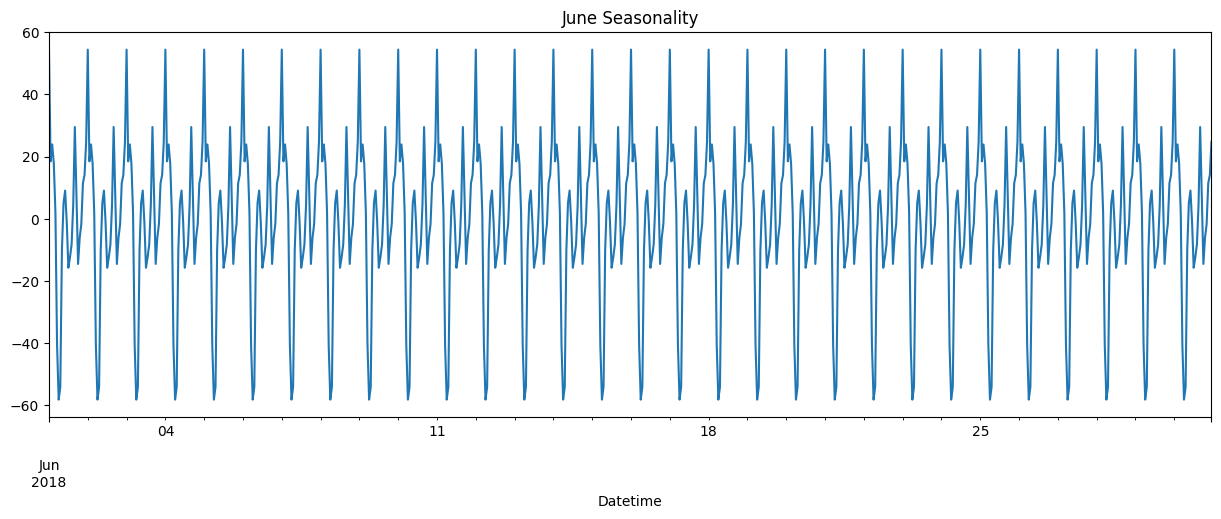

In [23]:
decomposed.trend['2018-06-01':'2018-06-30'].plot(figsize = (15, 5))
plt.title('June Trend')
plt.xlabel('Datetime')
plt.show()

decomposed.seasonal['2018-06-01':'2018-06-30'].plot(figsize = (15, 5))
plt.title('June Seasonality')
plt.xlabel('Datetime')
plt.show()

Though June's trend plot has the same y-axis values as May's trend plot, there is a noticeable upward trend. Seasonality is still the same as ever.

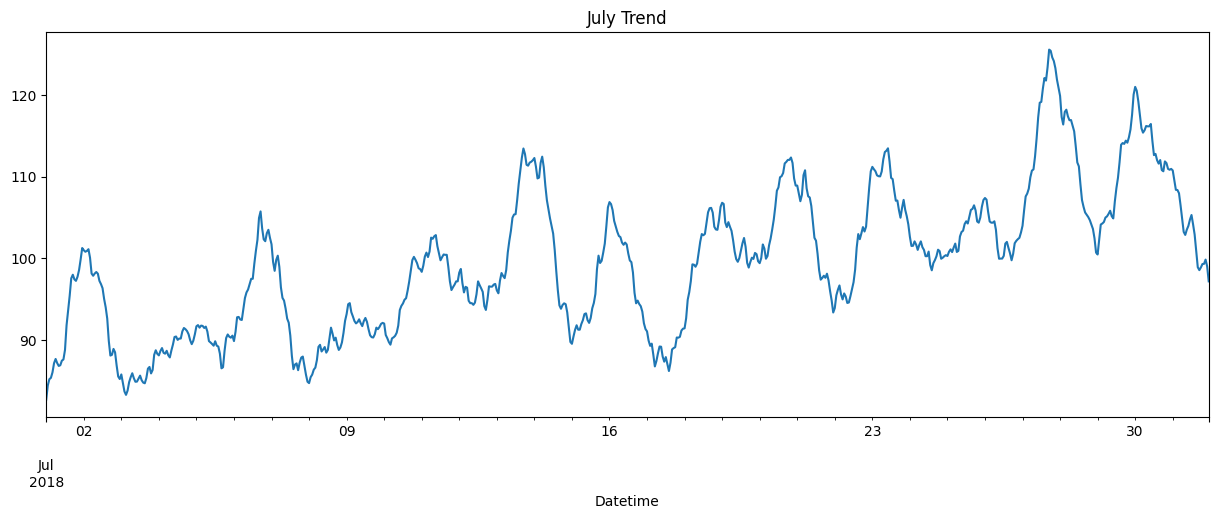

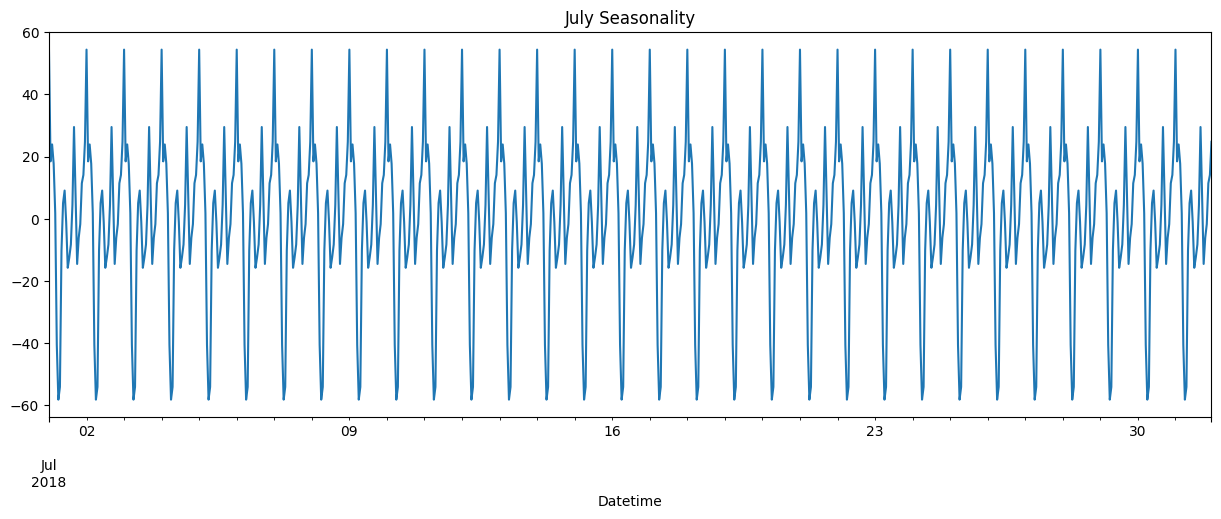

In [24]:
decomposed.trend['2018-07-01':'2018-07-31'].plot(figsize = (15, 5))
plt.title('July Trend')
plt.xlabel('Datetime')
plt.show()

decomposed.seasonal['2018-07-01':'2018-07-31'].plot(figsize = (15, 5))
plt.title('July Seasonality')
plt.xlabel('Datetime')
plt.show()

July's trend plot has overall larger y-axis values than June's, which indicates that the upward trend is continuing. This makes sense because July is the middle of the summer, so I would expect that many people would want to travel during a month when the weather is fantastic (presumably at least). 

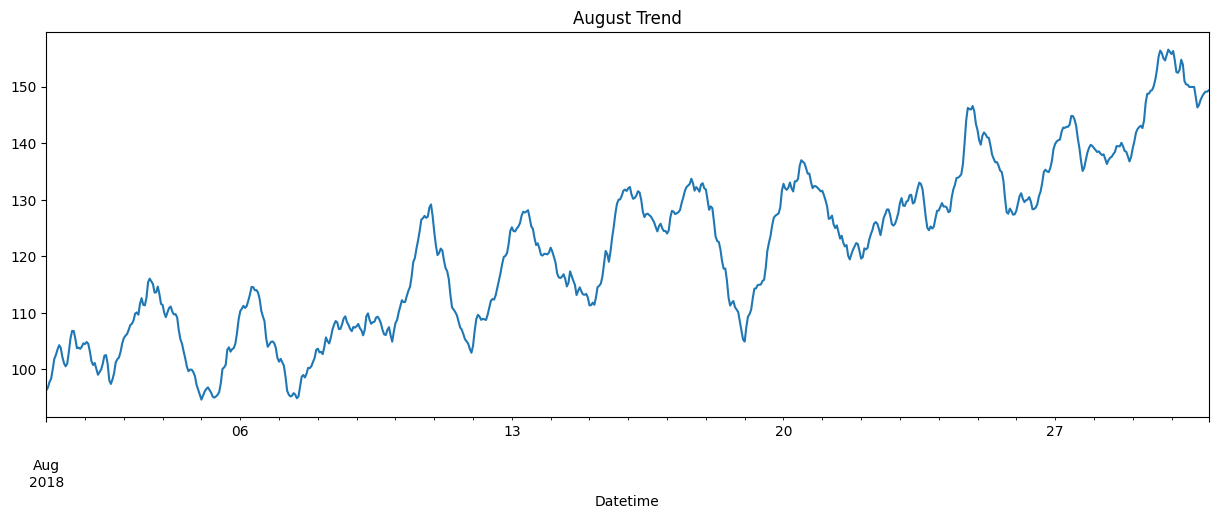

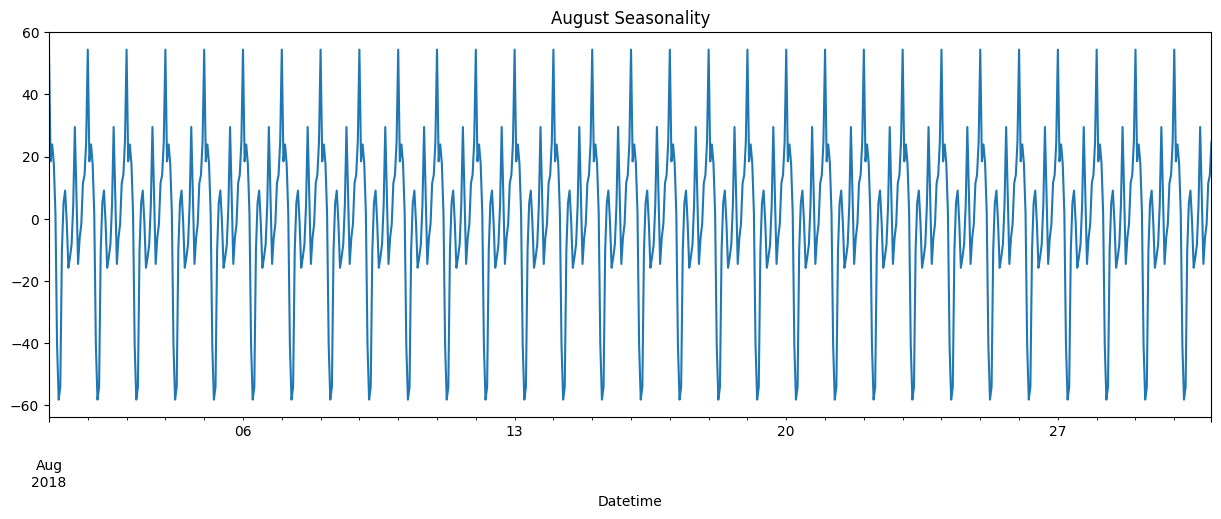

In [25]:
decomposed.trend['2018-08-01':'2018-08-30'].plot(figsize = (15, 5))
plt.title('August Trend')
plt.xlabel('Datetime')
plt.show()

decomposed.seasonal['2018-08-01':'2018-08-30'].plot(figsize = (15, 5))
plt.title('August Seasonality')
plt.xlabel('Datetime')
plt.show()

Once again, the y-axis values of the trend plot have increased, meaning the upward trend continues throughout August. This makes sense because I'm sure a lot of people plan their vacations in August when the weather is still nice, and likely not as hot as July since the transition to autumn is happening. Speaking of the transition, August is the last month where a person can take a summer vacation before they would need to wait nearly a whole year to take another.

Just like the spring months, I think it is a good idea to have a trend plot of all three summer months: June, July, and August.

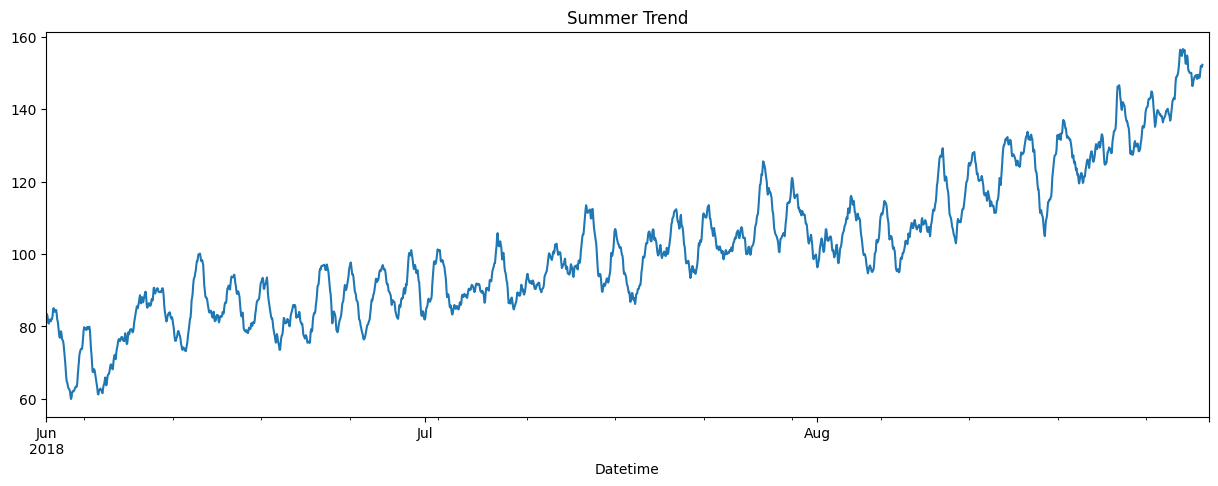

In [26]:
decomposed.trend['2018-06-01':'2018-08-31'].plot(figsize = (15, 5))
plt.title('Summer Trend')
plt.xlabel('Datetime')
plt.show()

The y-axis values really put into perspective how much the demand for taxi rides increased throughout the summer. On the **Spring Trend** graph, the y-axis values range from 40 to 100, and on this graph the y-axis values range from 60 to 160!

**Taxis Ordered By Hour of Day, Day of Week, and Month of Year** <a id=6.4></a>

Before I begin training different models, I will make bar graphs of the typical number of taxis ordered by hour of day, then by day of the week, and finally by month of the year. 

For each of the three time variables, I will plot both the mean <u>AND</u> the median values to see if there are any significant differences between using those two aggregate values (this might happen because the median is less susceptible to outliers than the mean).

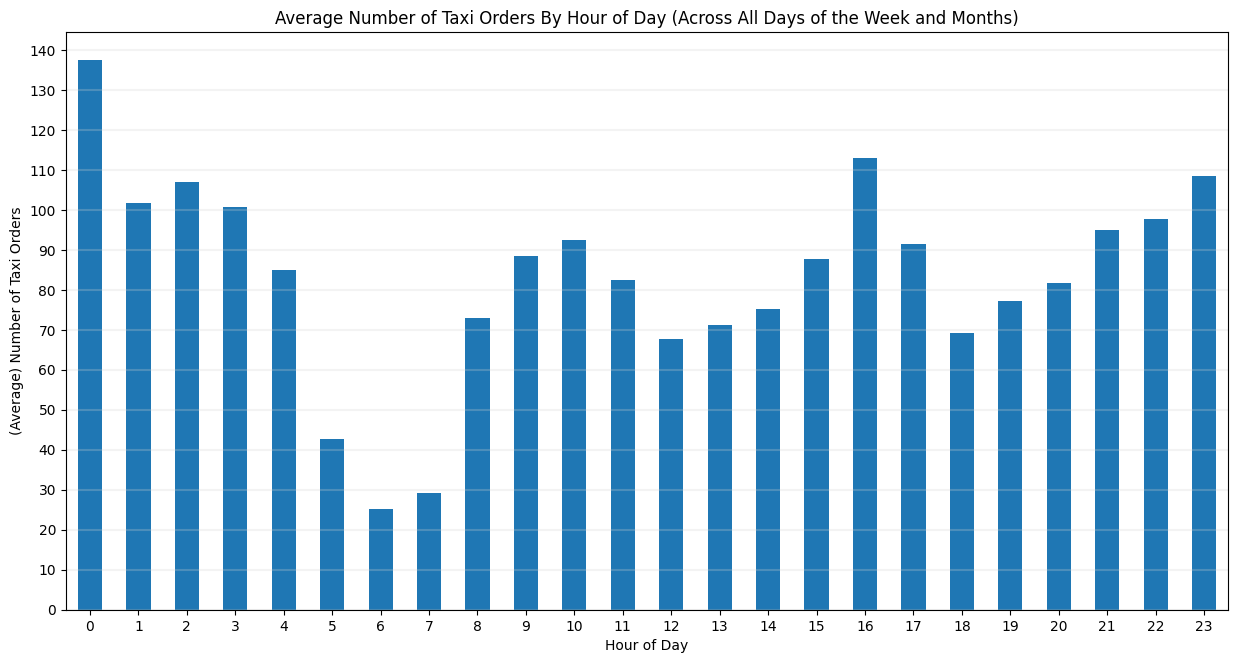

In [27]:
plt.figure(figsize = (15, 7.5))
data_reindexed.groupby(data_reindexed.index.hour)['num_orders_hourly'].mean().plot(kind = 'bar', ax = plt.gca())

plt.title('Average Number of Taxi Orders By Hour of Day (Across All Days of the Week and Months)')
plt.xlabel('Hour of Day')
plt.xticks(rotation = 0)
plt.ylabel('(Average) Number of Taxi Orders')
plt.yticks(np.arange(0, 150, 10))

for y_tick in plt.gca().get_yticks():
    plt.axhline(y = y_tick, color = 'lightgray', linestyle = '-', alpha = 0.25)

It makes sense that the bar graph looks like this because, as pointed out when I analyzed the seasonality plots, the number of taxi orders is large at the start of the day, but between then and about 1/4 of the way into the day (hours 5 and 6) the number of taxi orders goes down (**especially** from hour 4 to hour 5). From hour 7 onward, however, the number of taxi orders per hour mostly increases, with two relatively small "dips" until the day is over.

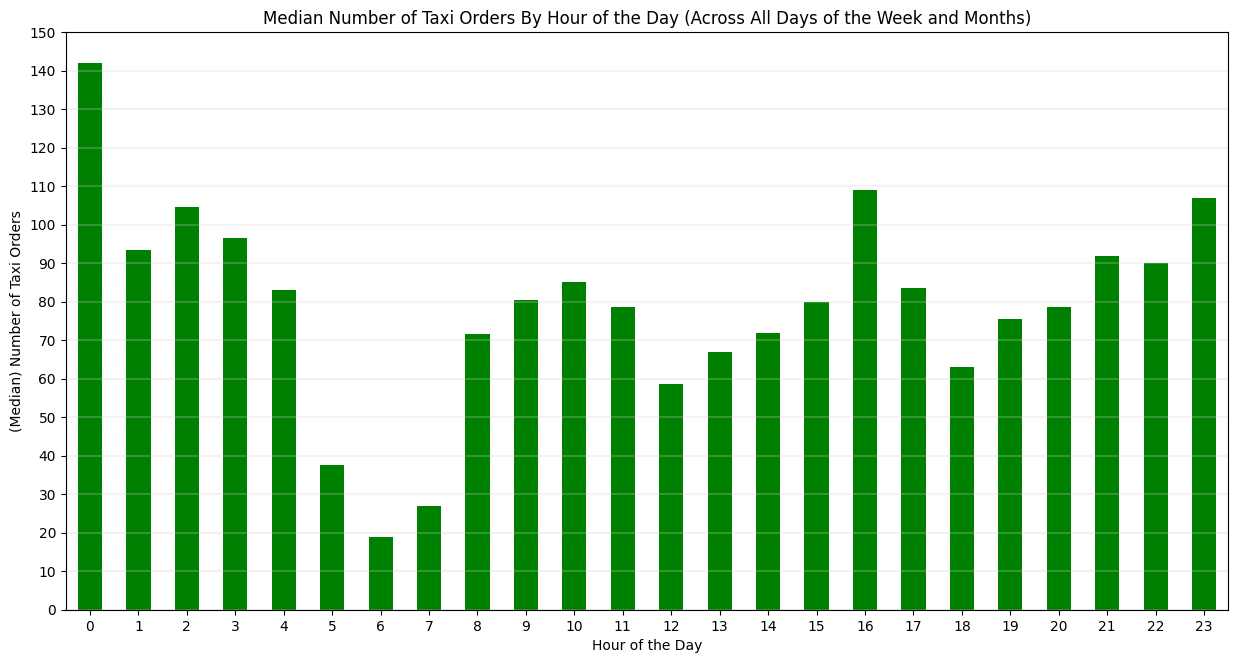

In [28]:
plt.figure(figsize = (15, 7.5))
data_reindexed.groupby(data_reindexed.index.hour)['num_orders_hourly'].median().plot(kind = 'bar', ax = plt.gca(), 
                                                                                     color = 'green')

plt.title('Median Number of Taxi Orders By Hour of the Day (Across All Days of the Week and Months)')
plt.xlabel('Hour of the Day')
plt.xticks(rotation = 0)
plt.ylabel('(Median) Number of Taxi Orders')
plt.yticks(np.arange(0, 160, 10))

for y_tick in plt.gca().get_yticks():
    plt.axhline(y = y_tick, color = 'lightgray', linestyle = '-', alpha = 0.25)

Interesting! The distribution is practically the same when using the median values! This further supports my interpretation of the seasonality plots.

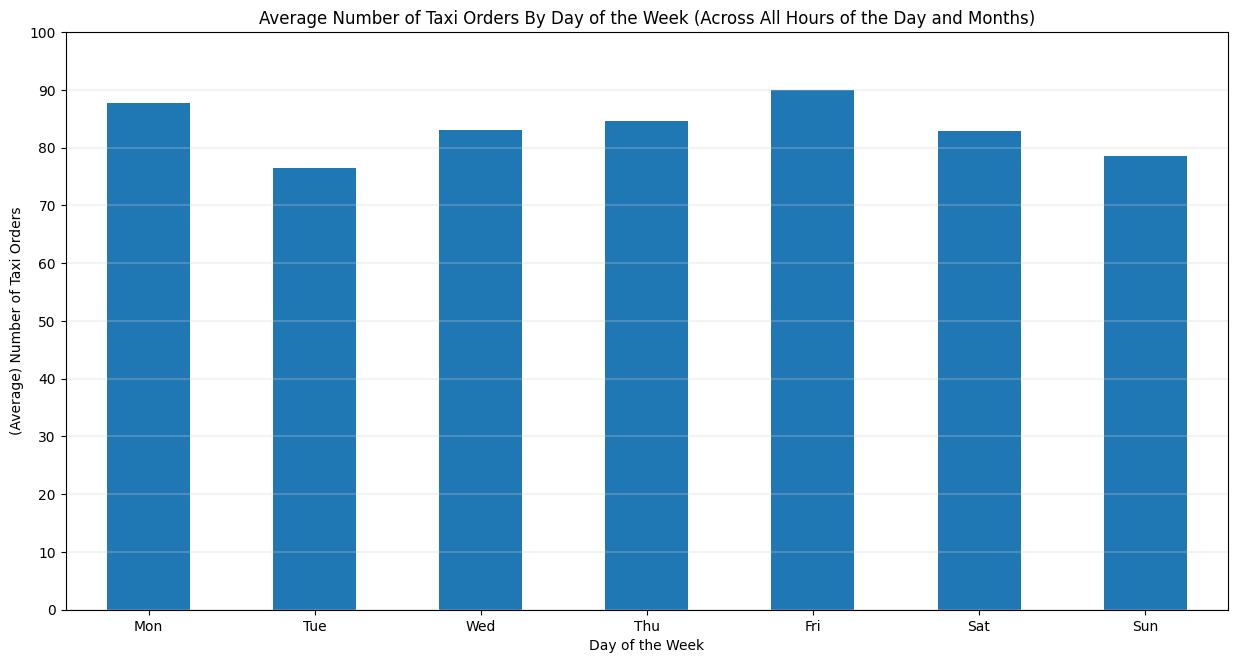

In [29]:
days_of_week = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

plt.figure(figsize = (15, 7.5))
data_reindexed.groupby(data_reindexed.index.dayofweek)['num_orders_hourly'].mean().plot(kind = 'bar', ax = plt.gca())

plt.title('Average Number of Taxi Orders By Day of the Week (Across All Hours of the Day and Months)')
plt.xlabel('Day of the Week')
plt.xticks(rotation = 0)
plt.xticks(range(len(days_of_week)), days_of_week)
plt.ylabel('(Average) Number of Taxi Orders')
plt.yticks(np.arange(0, 110, 10))

for y_tick in plt.gca().get_yticks():
    plt.axhline(y = y_tick, color = 'lightgray', linestyle = '-', alpha = 0.25)

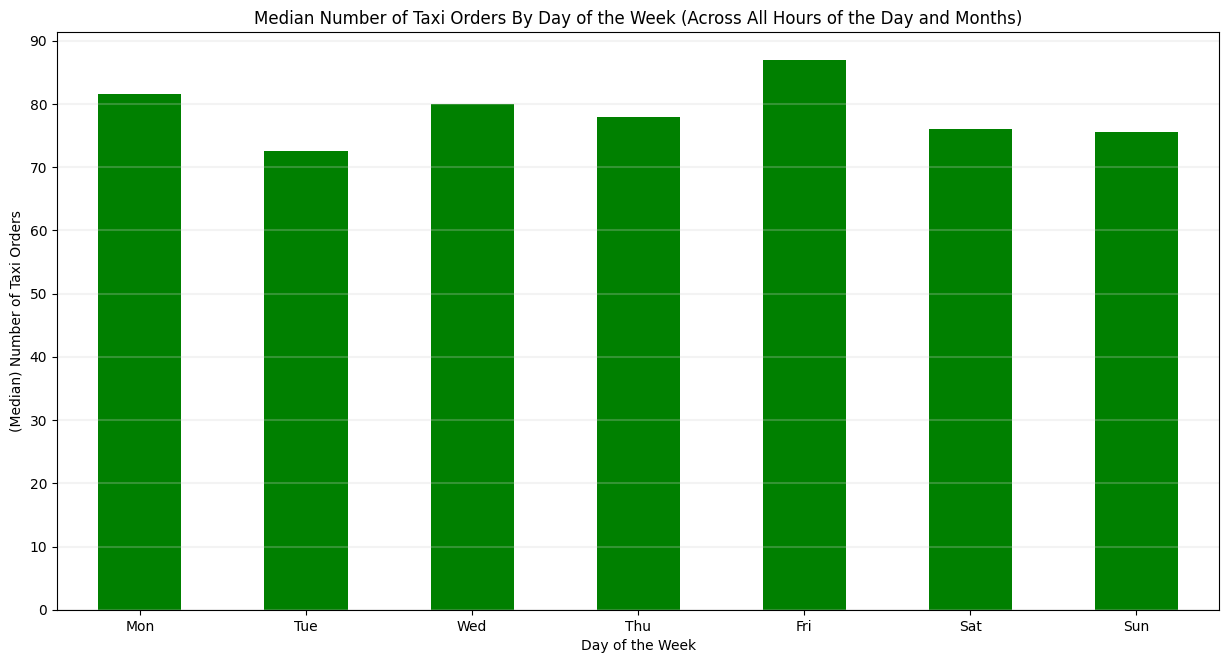

In [30]:
plt.figure(figsize = (15, 7.5))
data_reindexed.groupby(data_reindexed.index.dayofweek)['num_orders_hourly'].median().plot(kind = 'bar', ax = plt.gca(),
                                                                                         color = 'green')

plt.title('Median Number of Taxi Orders By Day of the Week (Across All Hours of the Day and Months)')
plt.xlabel('Day of the Week')
plt.xticks(rotation = 0)
plt.xticks(range(len(days_of_week)), days_of_week)
plt.ylabel('(Median) Number of Taxi Orders')
plt.yticks(np.arange(0, 100, 10))

for y_tick in plt.gca().get_yticks():
    plt.axhline(y = y_tick, color = 'lightgray', linestyle = '-', alpha = 0.25)

Fascinating! Earlier in my analysis I noticed that it is common for Mondays and (late) Fridays to be days where a local maximum number of taxi orders are made, but the local maximums are not frequent and/or drastic enough to cause Mondays and Fridays to have a tremendously higher number of taxi orders per hour than the other days of the week. 

Every day of the week, the average number of taxis ordered per hour is greater than 75 and less than 95. Similarly, the median number of taxis ordered per hour is greater than 70 and less than 90 every day of the week. My practical takeaway for Sweet Lift Taxi is that the number of taxi drivers they need to hire is approximately equal across every day of the week.

With all that said, it is worth mentioning that using both aggregate values, Friday takes 1st place, Monday takes 2nd place, and Tuesday takes last place.

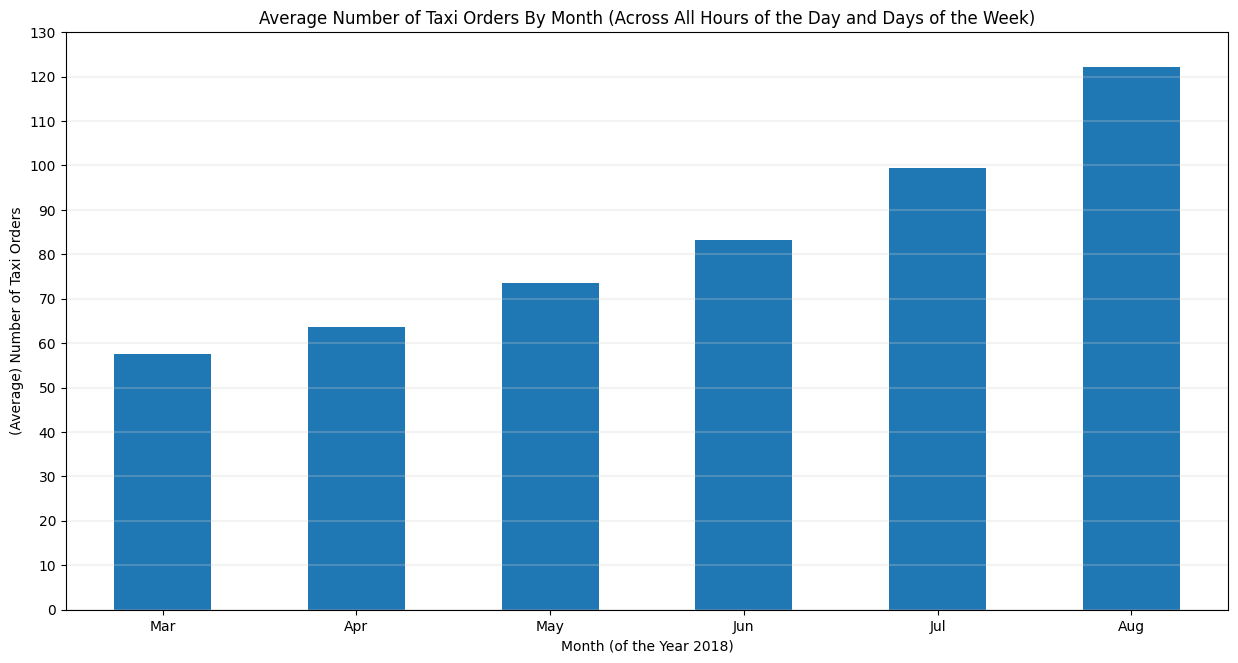

In [31]:
months = ['Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']

plt.figure(figsize = (15, 7.5))
data_reindexed.groupby(data_reindexed.index.month)['num_orders_hourly'].mean().plot(kind = 'bar', ax = plt.gca())

plt.title('Average Number of Taxi Orders By Month (Across All Hours of the Day and Days of the Week)')
plt.xlabel('Month (of the Year 2018)')
plt.xticks(rotation = 0)
plt.xticks(range(len(months)), months)
plt.ylabel('(Average) Number of Taxi Orders')
plt.yticks(np.arange(0, 140, 10))

for y_tick in plt.gca().get_yticks():
    plt.axhline(y = y_tick, color = 'lightgray', linestyle = '-', alpha = 0.25)

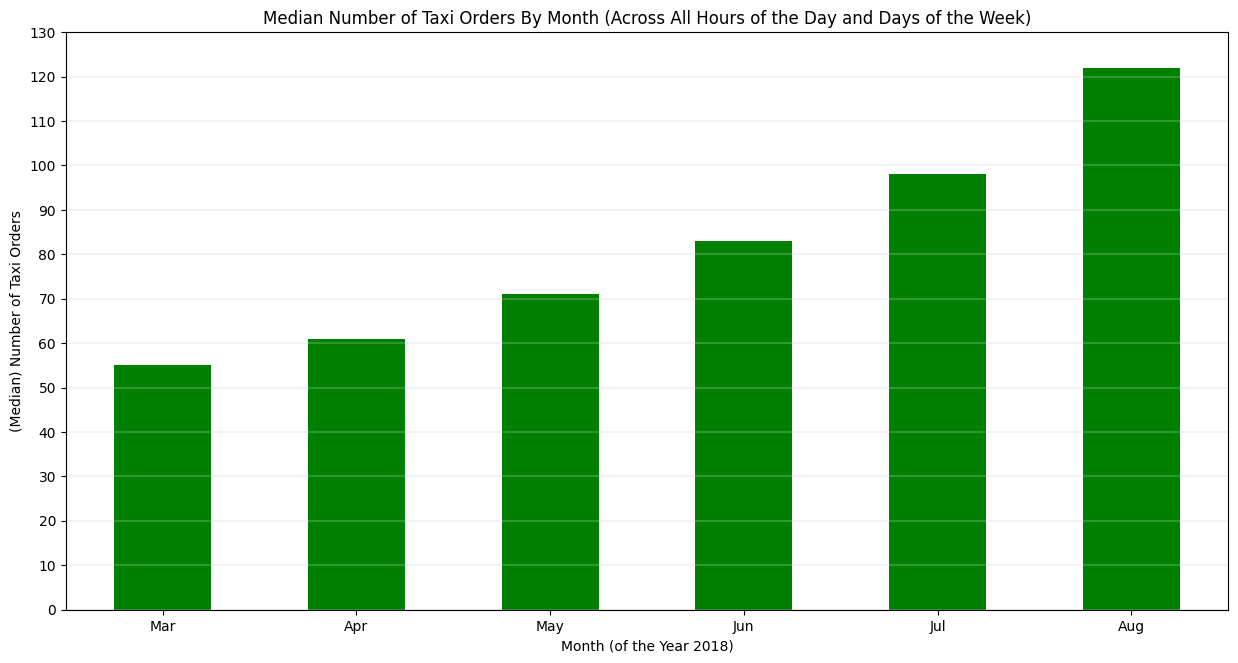

In [32]:
plt.figure(figsize = (15, 7.5))
data_reindexed.groupby(data_reindexed.index.month)['num_orders_hourly'].median().plot(kind = 'bar', ax = plt.gca(),
                                                                                     color = 'green')

plt.title('Median Number of Taxi Orders By Month (Across All Hours of the Day and Days of the Week)')
plt.xlabel('Month (of the Year 2018)')
plt.xticks(rotation = 0)
plt.xticks(range(len(months)), months)
plt.ylabel('(Median) Number of Taxi Orders')
plt.yticks(np.arange(0, 140, 10))

for y_tick in plt.gca().get_yticks():
    plt.axhline(y = y_tick, color = 'lightgray', linestyle = '-', alpha = 0.25)

Just like with the hours of the day and (to a slightly less extent) the days of the week bar graphs, there is practically no difference between the mean and the median number of taxi orders when looking at them by month. In both cases, taxi orders at airports become more common as spring turns to summer and again throughout the summer months. This further supports my hunch from earlier that the summer months are perceived as more ideal for travel than the spring months, due to the (presumably) better weather. 

# Model Training & Testing <a id=7></a>

**Features Engineering** <a id=7.1></a>

Before I can train any models, I must create the features, namely calendar features, lag features, and the rolling mean. I know I made a **rolling_mean** column earlier in this project, but I will delete that one in the next line to make way for an updated one.

In [33]:
data_reindexed = data_reindexed.drop('rolling_mean', axis = 1)

The next line contains a function for creating the features.

In [34]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['day'] = data.index.day
    data['month'] = data.index.month
    data['day_of_week'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders_hourly'].shift(lag)

    data['rolling_mean'] = data['num_orders_hourly'].shift().rolling(rolling_mean_size).mean()
    
    return data

In [35]:
data_with_features = make_features(data_reindexed, 4, 4)

display(data_with_features.sample(10))

,num_orders_hourly,hour,day,month,day_of_week,lag_1,lag_2,lag_3,lag_4,rolling_mean
datetime,,,,,,,,,,
2018-08-10 06:00:00,44,6,10,8,4,47.0,122.0,80.0,186.0,108.75
2018-04-11 08:00:00,60,8,11,4,2,20.0,9.0,23.0,25.0,19.25
2018-05-17 22:00:00,91,22,17,5,3,83.0,77.0,73.0,41.0,68.50
2018-08-12 17:00:00,115,17,12,8,6,153.0,149.0,104.0,120.0,131.50
2018-06-04 15:00:00,52,15,4,6,0,86.0,69.0,71.0,103.0,82.25
2018-06-07 01:00:00,100,1,7,6,3,156.0,48.0,75.0,89.0,92.00
2018-03-04 06:00:00,11,6,4,3,6,22.0,27.0,42.0,26.0,29.25
2018-06-17 01:00:00,92,1,17,6,6,131.0,103.0,74.0,81.0,97.25
2018-06-29 04:00:00,95,4,29,6,4,91.0,100.0,87.0,161.0,109.75


Great! Judging by the random sample of 10 rows, it appears that the function works correctly.

<u>SIDE NOTE</u>: There are two reasons why I chose 4 as the (new) rolling_mean_size value: (1) I wanted to pick a number that is divisible by 24, since there are 24 hours in a day. (2) I could have picked 2, 3, 4, 6, or 12, and I decided that 4 is the "sweet spot", not too small, but also not too large.

Now let's make the training, validation, and test sets. Recall that the test set is meant to contain the last 10% of the data. In my experience thus far, the validation set tends to be the same size as the test set, so I will make the validation set contain the second to last 10% of the data.

In [36]:
train, valid_and_test = train_test_split(data_with_features, shuffle = False, test_size = 0.2, random_state = 12345)

valid, test = train_test_split(valid_and_test, shuffle = False, test_size = 0.5, random_state = 12345)

train = train.dropna()
features_train = train.drop(['num_orders_hourly'], axis = 1)
target_train = train['num_orders_hourly']

features_valid = valid.drop(['num_orders_hourly'], axis = 1)
target_valid = valid['num_orders_hourly']

features_test = test.drop(['num_orders_hourly'], axis = 1)
target_test = test['num_orders_hourly']

**Linear Regression** <a id=7.2></a>

Let's see if a linear regression model is good enough for this data. Recall that the RMSE metric on the test set may not be more than 48.

In [37]:
%%time

lr_model = LinearRegression()
lr_model.fit(features_train, target_train)

CPU times: total: 46.9 ms
Wall time: 27.4 ms


LinearRegression()

In [38]:
%%time

lr_pred_train = lr_model.predict(features_train)
lr_pred_valid = lr_model.predict(features_valid)

CPU times: total: 0 ns
Wall time: 4.08 ms


In [39]:
print("RMSE of the linear regression for the training set:", 
      round(np.sqrt(mean_squared_error(target_train, lr_pred_train)), 2))

print("RMSE of the linear regression for the validation set: ", 
      round(np.sqrt(mean_squared_error(target_valid, lr_pred_valid)), 2))

RMSE of the linear regression for the training set: 28.53
RMSE of the linear regression for the validation set:  35.43


The wall time of the linear regression model is extremely short (which is a very good thing), and the RMSE values of both sets are (considerably) less than 48! 

Though I could stop here and recommend this linear regression model to Sweet Lift Taxi, it is best practice to try multiple different models.

**Random Forest** <a id=7.3></a>

In [40]:
%%time

rf_model = RandomForestRegressor(random_state = 12345)
rf_model.fit(features_train, target_train)

CPU times: total: 578 ms
Wall time: 1.84 s


RandomForestRegressor(random_state=12345)

In [41]:
%%time

rf_pred_train = rf_model.predict(features_train)
rf_pred_valid = rf_model.predict(features_valid)

CPU times: total: 31.2 ms
Wall time: 56.5 ms


In [42]:
print("RMSE of the random forest for the training set:", 
      round(np.sqrt(mean_squared_error(target_train, rf_pred_train)), 2))

print("RMSE of the random forest for the validation set: ", 
      round(np.sqrt(mean_squared_error(target_valid, rf_pred_valid)), 2))

RMSE of the random forest for the training set: 7.68
RMSE of the random forest for the validation set:  27.33


It concerns me that the RMSE of the training set is so much smaller than that of the test set. Maybe the model is overfitting the training set?

Additionally, this model's wall time is noticeably longer than that of the Linear Regression.

Maybe doing some hyperparameter tuning will fix one or both of these issues?

Let's print the default hyperparameter values in order to help me decide what I might want to change them to.

In [43]:
print(rf_model.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 12345, 'verbose': 0, 'warm_start': False}


GridSearchCV can find hyperparameter values that, hopefully, reduce, the RMSE of the test set, the apparent overfitting of the training set, and the wall time.

The GridSearchCV done on the next line takes a very long time to run, so I deliberately commented it out. 

In [44]:
#hyperparameters_rf_model = {'max_depth': np.arange(1, 21, 1), 
#                            'min_samples_leaf': np.arange(1, 11, 1),  
#                            'n_estimators': np.arange(10, 110, 10)}


#grid_search_rf_model = GridSearchCV(estimator = RandomForestRegressor(), param_grid = hyperparameters_rf_model,
#                                    scoring = 'neg_root_mean_squared_error', cv = TimeSeriesSplit(n_splits = 3))

#grid_search_rf_model.fit(features_train, target_train)

#print(grid_search_rf_model.best_params_)

Let's now assess the random forest model using the values found using GridSearchCV.

In [45]:
%%time

rf_model_tuned = RandomForestRegressor(max_depth = 20, min_samples_leaf = 3,
                                       n_estimators = 90, random_state = 12345)

rf_model_tuned.fit(features_train, target_train)

CPU times: total: 375 ms
Wall time: 1.15 s


RandomForestRegressor(max_depth=20, min_samples_leaf=3, n_estimators=90,
                      random_state=12345)

In [46]:
%%time

rf_tuned_pred_train = rf_model_tuned.predict(features_train)
rf_tuned_pred_valid = rf_model_tuned.predict(features_valid)

CPU times: total: 15.6 ms
Wall time: 45.9 ms


In [47]:
print("RMSE of the TUNED random forest for the training set:", 
      round(np.sqrt(mean_squared_error(target_train, rf_tuned_pred_train)), 2))

print("RMSE of the TUNED random forest for the validation set: ", 
      round(np.sqrt(mean_squared_error(target_valid, rf_tuned_pred_valid)), 2))

RMSE of the TUNED random forest for the training set: 11.51
RMSE of the TUNED random forest for the validation set:  27.23


This result, though an improvement over the default random forest, is disappointing. 

The RMSE of the validation set is only a **TINY** bit smaller compared to the default random forest. 

Furthermore, the gap between the training set's RMSE value and the validation set's RMSE value, though smaller than that of the default random forest model, is still large, which suggests that overfitting is still happening. 

Lastly, though the wall time is shorter compared to that of the default random forest, it is still longer than that of the linear regression. 

**LightGBM Regressor** <a id=7.4></a>

In [48]:
%%time

lgbm_model = LGBMRegressor(random_state = 12345)
lgbm_model.fit(features_train, target_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1004
[LightGBM] [Info] Number of data points in the train set: 3528, number of used features: 9
[LightGBM] [Info] Start training from score 74.175737
CPU times: total: 656 ms
Wall time: 213 ms


LGBMRegressor(random_state=12345)

In [49]:
%%time

lgbm_pred_train = lgbm_model.predict(features_train)
lgbm_pred_valid = lgbm_model.predict(features_valid)

CPU times: total: 109 ms
Wall time: 16.7 ms


In [50]:
print("RMSE of the LightGBM regressor for the training set:", 
      round(np.sqrt(mean_squared_error(target_train, lgbm_pred_train)), 2))

print("RMSE of the LightGBM regressor for the validation set: ", 
      round(np.sqrt(mean_squared_error(target_valid, lgbm_pred_valid)), 2))

RMSE of the LightGBM regressor for the training set: 13.66
RMSE of the LightGBM regressor for the validation set:  27.25


This model is very promising! The RMSE of the validation set is approximately equal to that of the tuned random forest, and its wall time is much shorter. 

The gap between the RMSE values is smaller than that of the tuned random forest, but it is still quite large, which implies overfitting. 

Let's see if hyperparameter tuning reduces the RMSE even more, and/or reduces the overfitting. 

(Just like with the random forest GridSearchCV, I commented out the GridSearchCV, after I found the best hyperparameter values, on the next line because running it would take a long time.)

In [51]:
print(lgbm_model.get_params())

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 12345, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


In [52]:
#hyperparameters_lgbm_model = {'learning_rate': [0.1, 0.15, 0.2], 'max_depth': np.arange(-1, 11, 1),
#                              'n_estimators': np.arange(50, 155, 5), 'num_leaves': np.arange(2, 32, 1)}
                              
#grid_search_lgbm_model = GridSearchCV(estimator = LGBMRegressor(), param_grid = hyperparameters_lgbm_model,
#                                      scoring = 'neg_root_mean_squared_error', cv = TimeSeriesSplit(n_splits = 3))

#grid_search_lgbm_model.fit(features_train, target_train)

#print(grid_search_lgbm_model.best_params_)

In [53]:
%%time

lgbm_model_tuned = LGBMRegressor(learning_rate = 0.1, max_depth = 5, n_estimators = 105, 
                                 num_leaves = 5, random_state = 12345)

lgbm_model_tuned.fit(features_train, target_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1004
[LightGBM] [Info] Number of data points in the train set: 3528, number of used features: 9
[LightGBM] [Info] Start training from score 74.175737
CPU times: total: 109 ms
Wall time: 15.3 ms


LGBMRegressor(max_depth=5, n_estimators=105, num_leaves=5, random_state=12345)

In [54]:
%%time

lgbm_tuned_pred_train = lgbm_model_tuned.predict(features_train)
lgbm_tuned_pred_valid = lgbm_model_tuned.predict(features_valid)

CPU times: total: 0 ns
Wall time: 4.57 ms


In [55]:
print("RMSE of the TUNED LightGBM regressor for the training set:", 
      round(np.sqrt(mean_squared_error(target_train, lgbm_tuned_pred_train)), 2))

print("RMSE of the TUNED LightGBM regressor for the validation set: ", 
      round(np.sqrt(mean_squared_error(target_valid, lgbm_tuned_pred_valid)), 2))

RMSE of the TUNED LightGBM regressor for the training set: 20.05
RMSE of the TUNED LightGBM regressor for the validation set:  28.17


Great! At first glance, this tuned LightGBM appears to be worse than the default one, but in actuality it is better, overall.

The RMSE value of the validation set is slightly higher (specifically, by less than 1) than that of the default LightGBM, and also the RMSE value of the training set is much higher, but the gap between the two RMSE values is much smaller, suggesting that there is much less (if any) overfitting. 

In fact, the gap between the RMSE values is now approximately the same size as that of linear regression model, but with smaller values.

Furthermore, the wall time is once again extremely short (even shorter than that of the default LightGBM).

I could continue training different models, but I see no good reason to because I have already found a model that is computationally inexpensive, and that seems to be able to acquire RMSE values which are less than 48.

For the sake of thoroughness, let's assess the tuned LightGBM regressor one last time, using the test set.

In [56]:
lgbm_tuned_pred_test = lgbm_model_tuned.predict(features_test)

print("RMSE of the TUNED LightGBM regressor for the test set: ", 
      round(np.sqrt(mean_squared_error(target_test, lgbm_tuned_pred_test)), 2))

RMSE of the TUNED LightGBM regressor for the test set:  41.79


Good! Though this RMSE value is noticeably larger than that of the validation set, it is still less than 48 meaning this model "passes the test", so to speak.

I think this relatively large RMSE value can be explained by the fact that the last 10% of the data contains relatively large numbers of taxi rides, larger than those in the first 80% and those in the next 10% of the data. Hence, the model is having a harder time with accurately predicting the number of taxi rides that were needed throughout the last 10% of hours in the dataset. This, I think, is understandable and to be expected.

Since I have decided to use the tuned LightGBM regressor, I think it would be good to have a plot of how this model's predictions of the target values of the test set compare to the actual target values of the test set.

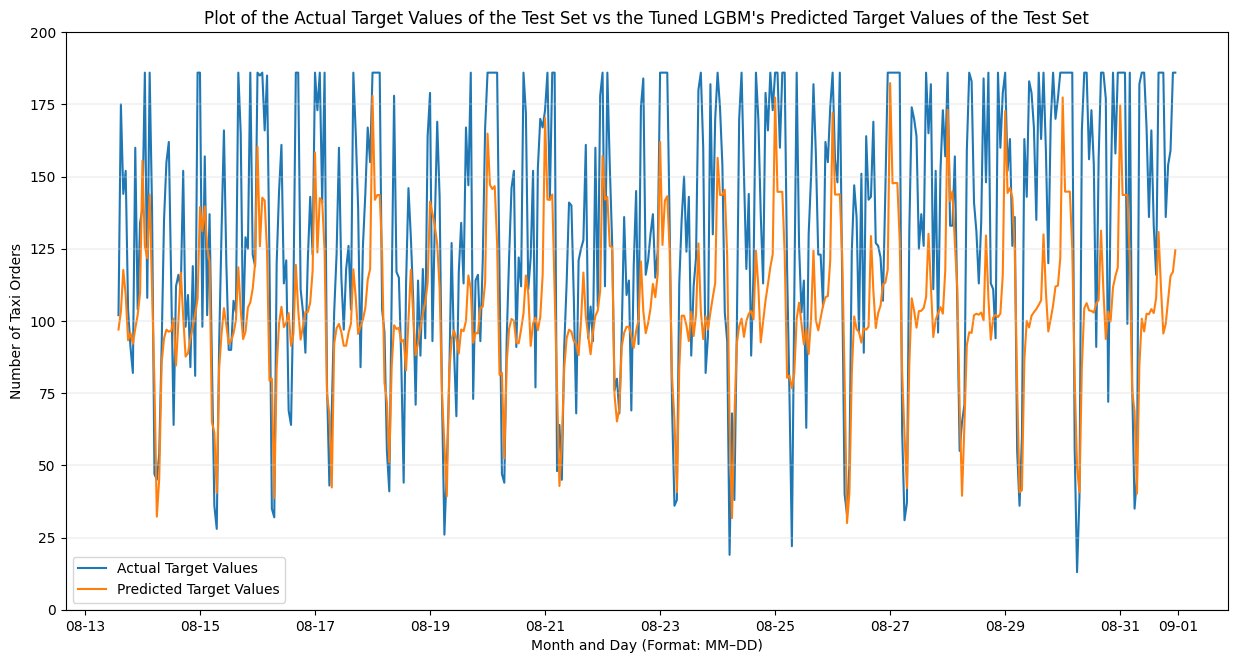

In [57]:
target_test_values = target_test.tolist()
target_test_index = target_test.index.tolist()
pred_test_values = lgbm_tuned_pred_test.tolist()

plt.figure(figsize = (15, 7.5))

plt.plot(target_test_index, target_test_values, label = "Actual Target Values")
plt.plot(target_test_index, pred_test_values, label = "Predicted Target Values")

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.legend()
plt.title("Plot of the Actual Target Values of the Test Set vs the Tuned LGBM's Predicted Target Values of the Test Set")
plt.xlabel('Month and Day (Format: MM–DD)')
plt.ylabel('Number of Taxi Orders')
plt.yticks(np.arange(0, 225, 25))

for y_tick in plt.gca().get_yticks():
    plt.axhline(y = y_tick, color = 'lightgray', linestyle = '-', alpha = 0.25)

plt.show()

Wonderful! The two plots are quite similar to one another, which is exactly what one would hope would happen.

(With that said, it is worth mentioning that there appear to be many instances where the predicted target value considerably underestimates the actual target value. This, I think, is understandable and to be expected given that the actual values in the last 10% of the dataframe are considerably larger, on average, than the values elsewhere in the dataframe.)

**Sanity Check** <a id=7.5></a>

As a sanity check, let's compare the tuned LightGBM regressor with a model that predicts **num_orders_hourly** values using the previous value.

In [58]:
previous_values_train = target_train.shift(1)
previous_values_valid = target_valid.shift(1)
previous_values_test = target_test.shift(1)

previous_values_train.fillna(method = 'bfill', inplace = True)
previous_values_valid.fillna(method = 'bfill', inplace = True)
previous_values_test.fillna(method = 'bfill', inplace = True)

print("RMSE of the previous value baseline for the training set:", 
      round(np.sqrt(mean_squared_error(target_train[1:], previous_values_train[1:])), 2))

print("RMSE of the previous value baseline for the validation set:", 
      round(np.sqrt(mean_squared_error(target_valid[1:], previous_values_valid[1:])), 2))

print("RMSE of the previous value baseline for the test set: ", 
      round(np.sqrt(mean_squared_error(target_test[1:], previous_values_test[1:])), 2))

RMSE of the previous value baseline for the training set: 33.86
RMSE of the previous value baseline for the validation set: 41.22
RMSE of the previous value baseline for the test set:  43.94


C:\Users\18604\AppData\Local\Temp\ipykernel_48820\3738497415.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  previous_values_train.fillna(method = 'bfill', inplace = True)
C:\Users\18604\AppData\Local\Temp\ipykernel_48820\3738497415.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  previous_values_valid.fillna(method = 'bfill', inplace = True)
C:\Users\18604\AppData\Local\Temp\ipykernel_48820\3738497415.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  previous_values_test.fillna(method = 'bfill', inplace = True)


Interestingly enough, this model would be good enough to use because its RMSE value for the test set is less than 48.

With that said, this model's RMSE value for the training set is 33.86, whereas that of the tuned LightGBM regressor is 20.05, a much better result!

Similarly, the tuned LightGBM regressor has a much smaller RMSE value for the validation set, 41.22 compared to 28.17.

Lastly, this model's RMSE value for the test set is 43.94, whereas that of the tuned LightGBM regressor is 41.79, a small yet noticeable difference.

This gives me assurance that Sweet Lift Taxi will find the tuned LightGBM regressor to be a useful and accurate (enough) machine learning model.

# Conclusion <a id=8></a>

Now that I have finished my analysis and model training/testing, below are my practical takeaways for Sweet Lift Taxi stakeholders:
- From 1st March 2018 to 31st August 2018, the middle 50% of the distribution of the number of taxis ordered at airports per hour was from 54 to 107. Hence, one can argue that a "typical" hour will have between 54 and 107 taxi orders.
- The trend plots reveal that while the number of taxis ordered throughout March 2018 was relatively constant, throughout the remaining months (April 2018 through August 2018) there is a clear upward trend in the number of taxis ordered per hour, likely because from spring to summer the weather becomes more desirable for travel in many locations.
- The seasonality is virtually the same every month. The number of taxi orders at the start of the day is high, then the number decreased until about 1/4 of the way into the day, and from there on the number increases.
- The days of the week with the most taxi orders are Fridays and Mondays (in that order), but not by much. The least busy day of the week is Tuesday, but again, not by much. This implies that Sweet Lift Taxi needs to hire approximately the same number of taxi drivers every day of the week.
- I successfully built a machine learning model that can predict the number of taxi orders for the next hour. It is a LightGBM regressor that is computationally inexpensive; the wall time for training the model and predicting with it was less than 1 second. Furthermore, after I tuned the model I was able to predict the target values of the test set with a root mean squared error of 41.79, which is considerably less than 48 (the maximum permitted RMSE value). 